In [1]:
import pandas as pd
import numpy as np
from scipy.stats.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
import os

### Getting the data

In [2]:
dataset = pd.read_pickle('../data/dataset_with_features.pickle')

In [3]:
features = dataset[['max_sentiment_english',
                   'max_sentiment_german',
                   'std_max_english_sentiment',
                   'std_max_german_sentiment',
                   'german_sentence_length',
                   'english_sentence_length',
                   'sentence_length_difference',
                   'verbs_diff',
                   'adjectives_diff',
                   'adverbs_diff',
                   'nouns_diff',
                   'non_translated_words',
                   'correlation',
                   'sentence_correlation',
                   'non_match_correlation',
                   'non_translated_ratio']]

In [30]:
train_val = features[:8000]
test = features[8000:]

In [40]:
dataset_features_list = list(train_val.columns)
dataset_features_arr = np.array(train_val)

In [32]:
test_features_arr = np.array(test)

In [6]:
path_train_scores = os.path.join(os.path.dirname(os.getcwd()), 'data', 'en-de', 'train.ende.scores')
train_scores = pd.read_csv(path_train_scores,header=None)
train_scores = train_scores.rename(columns={0:"scores"})
path_val_scores = os.path.join(os.path.dirname(os.getcwd()), 'data', 'en-de', 'dev.ende.scores')
val_scores = pd.read_csv(path_val_scores,header=None)
val_scores = val_scores.rename(columns={0:"scores"})
scores = pd.concat([train_scores, val_scores])

dataset_labels_arr = np.array(scores)

In [7]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

## CROSS VAL AND RESULTS

In [53]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import GridSearchCV

In [18]:
# normalised = (dataset_features_arr - dataset_features_arr.min(axis=0))/ \
#              (dataset_features_arr.max(axis=0) - dataset_features_arr.min(axis=0))
# normalised.var(axis=0)
# sel = VarianceThreshold(threshold=0.01)
# dataset_features_arr = sel.fit_transform(normalised)

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(1, 11, num = 11)]
min_samples_split = [2, 5, 10]
# min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, 
                               n_iter = 100, cv = 2, random_state=42, scoring='neg_mean_squared_error')
rf_random.fit(train_features, train_labels)
print(rf_random.best_params_)
print(rf_random.best_score_)

In [ ]:
importances = list(rf.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(dataset_features_list, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

### PLS

In [15]:
from sklearn.cross_decomposition import PLSRegression

In [16]:
n_components = [int(x) for x in np.arange(1,10)]
scale = [True, False]
max_iter = [int(x) for x in np.arange(300,1000)]

random_grid = {'n_components': n_components,
               'scale': scale, 
               'max_iter':max_iter}

pls = PLSRegression()
pls_random = RandomizedSearchCV(estimator = pls, param_distributions = random_grid, 
                                n_iter = 100, cv = 8, random_state=42, scoring='neg_mean_squared_error')
pls_random.fit(dataset_features_arr, dataset_labels_arr)
print(pls_random.best_params_)

{'scale': True, 'n_components': 8, 'max_iter': 347}


### Linear Regression

In [9]:
from sklearn.linear_model import Ridge

In [10]:
alpha = [x for x in np.linspace(0,1,10)]
normalize = [True, False]
max_iter = [int(x) for x in np.arange(300,1500)]

random_grid = {'alpha': alpha,
               'normalize': normalize, 
               'max_iter':max_iter}

lr = Ridge()
lr_random = RandomizedSearchCV(estimator = lr, param_distributions = random_grid, 
                                n_iter = 100, cv = 8, random_state=42, scoring='neg_mean_squared_error')
lr_random.fit(dataset_features_arr, dataset_labels_arr)
print(lr_random.best_params_)

{'normalize': True, 'max_iter': 1313, 'alpha': 0.1111111111111111}


### SVM

In [51]:
from sklearn.svm import SVR

In [ ]:
kernel = ('linear', 'poly', 'rbf')
C = [int(x) for x in np.linspace(1, 150, 10)]

random_grid = {'kernel': kernel,
               'C': C}
svm = SVR()
svm_random = RandomizedSearchCV(estimator = svm, param_distributions = random_grid, 
                                n_iter = 10, cv = 2, scoring='neg_mean_squared_error')
svm_random.fit(dataset_features_arr, dataset_labels_arr)
print(svm_random.best_params_)

In [55]:
# With SVM
svm = SVR()
parameters_svm = {'kernel':('linear', 'rbf', 'poly'), 'C':[1, 10, 50, 100]}
svm_grid = GridSearchCV(estimator=svm, param_grid=parameters_svm, cv=2, scoring='neg_mean_squared_error')
svm_grid.fit(dataset_features_arr, dataset_labels_arr.ravel())
print(svm_grid.best_params_)
print(svm_grid.best_score_)

{'C': 100, 'kernel': 'linear'}
-0.7076326146825924


## Mega Cross Val for the best

0.12713019488036142
0.4898581089010866


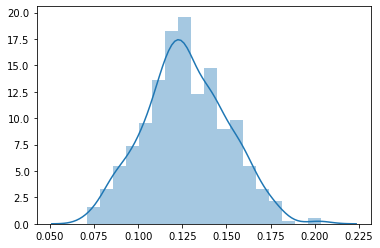

In [46]:
rs = ShuffleSplit(n_splits=500, test_size=.25, random_state=0)
cv = rs.split(dataset_features_arr)

correlation_ridge = []
mae_ridge = []
X = dataset_features_arr
y = dataset_labels_arr.reshape(-1)

for train, test in cv:
    rl = Ridge(**lr_random.best_params_)
    rl.fit(X[train], y[train])
    predictions = rl.predict(X[test]).reshape(-1)
    pearson = pearsonr(y[test], predictions)[0]
    error = abs(predictions - y[test])
    correlation_ridge.append(pearson)
    mae_ridge.append(error)
    
print(np.array(correlation_ridge).mean())
print(np.array(mae_ridge).mean())

In [ ]:
sns.distplot(correlation_ridge)
plt.xlabel('Pearson Correlation')
plt.ylabel('Counts')

#### PLS

0.12619948087061117
0.4903755530791514


Text(0.5, 0, 'Pearson Correlation')

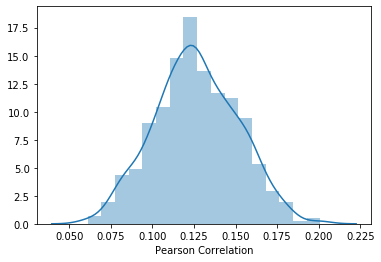

In [50]:
rs = ShuffleSplit(n_splits=500, test_size=.25, random_state=0)
cv = rs.split(dataset_features_arr)

correlation_pls = []
mae_pls = []
X = dataset_features_arr
y = dataset_labels_arr.reshape(-1)

for train, test in cv:
    pls = PLSRegression(**pls_random.best_params_)
    pls.fit(X[train], y[train])
    predictions = pls.predict(X[test]).reshape(-1)
    pearson = pearsonr(y[test], predictions)[0]
    error = abs(predictions - y[test])
    correlation_pls.append(pearson)
    mae_pls.append(error)
    
print(np.array(correlation_pls).mean())
print(np.array(mae_pls).mean())

In [ ]:
sns.distplot(correlation_pls)
plt.xlabel('Pearson Correlation')
plt.ylabel('Counts')

### SVM

In [ ]:
rs = ShuffleSplit(n_splits=10, test_size=.25, random_state=0)
cv = rs.split(dataset_features_arr)

correlation_svm = []
mae_svm = []
X = dataset_features_arr
y = dataset_labels_arr.reshape(-1)

for train, test in cv:
    svm = SVR(**svm_grid.best_params_)
    svm.fit(X[train], y[train])
    predictions = svm.predict(X[test]).reshape(-1)
    pearson = pearsonr(y[test], predictions)[0]
    error = abs(predictions - y[test])
    correlation_pls.append(pearson)
    mae_svm.append(error)
    
print(np.array(correlation_svm).mean())
print(np.array(mae_svm).mean())

sns.distplot(correlation_svm)

### Neural Network

In [ ]:
import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
import torch.optim as optim

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
import numpy as np
english_laser = np.load('../data/laser_1024_english.npy')
german_laser = np.load('../data/laser_1024_german.npy')

In [ ]:
english_laser_train = english_laser[:8000,:]
german_laser_train = german_laser[:8000,:]

In [ ]:
english_laser_train = np.array(english_laser_train)
german_laser_train = np.array(german_laser_train)

In [ ]:
laser_features = np.concatenate((english_laser_train, german_laser_train), axis=1)

In [ ]:
train_features = np.concatenate((laser_features[idx_train,:], train_features_baseline), axis = 1)
val_features = np.concatenate((laser_features[idx_test,:], val_features_baseline), axis = 1)
print(train_features.shape, val_features.shape)

In [ ]:
class Net(nn.Module):

    def __init__(self, x):
        super(Net, self).__init__()
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(x.shape[1], 3) 
        nn.init.xavier_uniform_(self.fc1.weight, gain=1.0)
        self.fc2 = nn.Linear(3, 2)
        nn.init.xavier_uniform_(self.fc2.weight, gain=1.0)
        self.fc3 = nn.Linear(2, 1)
        nn.init.xavier_uniform_(self.fc2.weight, gain=1.0)

    def forward(self, x):
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net = Net(train_features)
print(net)

In [ ]:
train_features_ten, train_labels_ten = Tensor(train_features), Tensor(train_labels.reshape(-1,1))

In [ ]:
means = train_features_ten.mean(dim=0, keepdim=True)
stds = train_features_ten.std(dim=0, keepdim=True)
normalized_train = (train_features_ten - means) / stds

In [ ]:
val_features_ten = (Tensor(val_features)- means) / stds
test_labels = Tensor((val_labels).reshape(-1, 1))

In [ ]:
train_data = TensorDataset(normalized_train, train_labels_ten)
train_loader = DataLoader(train_data, shuffle=True, batch_size=32)

In [ ]:
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=1e-4, betas=(0.5, 0.999))

In [ ]:
test_pearson=[]
for epoch in range(40):
    running_loss = 0.0
    for batch_idx, data in enumerate(train_loader):
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
    with torch.no_grad():
        predictions = net(val_features_ten)
        test_loss = criterion(predictions, test_labels).item()
        pearson = pearsonr(val_labels, predictions.numpy().reshape(-1,))[0]
        test_pearson.append(pearson)
#         print('Test Epoch: ', epoch, " ", pearson)
        
        #train correlation
        predictions = net(normalized_train)
        pearson = pearsonr(train_labels, predictions.numpy().reshape(-1,))[0]
#         print('Train Epoch: ', epoch, " ", pearson)
print(test_pearson.index(max(test_pearson)), max(test_pearson))
plt.plot(test_pearson)
#     print('Train loss', epoch, running_loss)
#     print('Test loss', epoch, test_loss)
print('Finished Training')

In [ ]:
net.eval()
predictions = net(val_features_ten).detach().numpy().reshape(-1,)

In [ ]:
pearson = pearsonr(val_labels, predictions)
errors = abs(predictions - val_labels)
print(f'RMSE: {rmse(predictions,val_labels)}')
print(f'Pearson {pearson[0]}')
print('Mean Absolute Error:', round(np.mean(errors), 4))
print()

## Predictions for test set

In [47]:
lr_test = Ridge(**lr_random.best_params_)
lr_test.fit(dataset_features_arr, dataset_labels_arr)
predictions = lr_test.predict(test_features_arr).reshape(-1,)

In [48]:
def writeScores(method_name,scores):
    fn = "predictions.txt"
    print("")
    with open(fn, 'w') as output_file:
        for idx,x in enumerate(scores):
            #out =  metrics[idx]+":"+str("{0:.2f}".format(x))+"\n"
            #print(out)
            output_file.write(f"{x}\n")

writeScores("model_name",predictions)

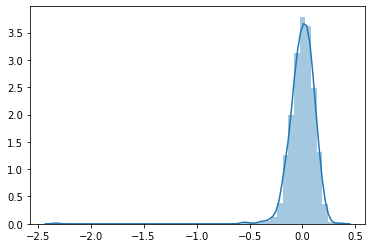

In [49]:
sns.distplot(predictions)